In [1]:
import pandas as pd
import os.path
import matplotlib as mpl
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{lmodern}"

In [2]:
langs = ['zh', 'ko', 'he', 'yo']
langs_order = ['en-zh', 'en-ko', 'en-he', 'en-yo']
models_order = ['gpt', 'palm', 'opus', 'nllb']
def m(x):
    if x == 'gpt': return "ChatGPT"
    if x == 'palm': return "PaLM 2"
    if x == 'opus': return 'Opus MT'
    if x == 'nllb': return 'NLLB'
    return None

In [3]:
rq1 = []
rq2 = []
rq3_fig = []
rq3_lit = []

for lang in langs:

    if not os.path.isfile(f"./human_evaluation/{lang}.csv"):  
        for model in ['gpt', 'palm', 'opus', 'nllb']:
            for i in range(50):
                rq1.append([model, lang, "N/A"])
                rq2.append([model, lang, "N/A"])
                rq3_fig.append([model, lang, "N/A"])
                rq3_lit.append([model, lang, "N/A"])
        continue

    df = pd.read_csv(f"./human_evaluation/{lang}.csv").fillna("")

    for i in range(0, len(df), 3):
        model = df.iloc[i]['source_model']
        if lang == 'ko' and model == 'opus':
            rq1.append([model, lang, "N/A"])
            rq2.append([model, lang, "N/A"])
            rq3_fig.append([model, lang, "N/A"])
            rq3_lit.append([model, lang, "N/A"])
            continue
            
        # rq1
        amb_afl = df.iloc[i]['afl'].strip()
        if amb_afl == 'f': rq1.append([model, lang, "Figurative"])
        elif amb_afl == 'l': rq1.append([model, lang, "Literal"])
        elif amb_afl == 'a': rq1.append([model, lang, "Ambiguous"])
        elif amb_afl == 'x': rq1.append([model, lang, "Nonsense"])
        else: rq1.append([model, lang, "N/A"])

        # rq2
        fig_afl = df.iloc[i + 1]['afl'].strip()
        lit_afl = df.iloc[i + 2]['afl'].strip()
        if {fig_afl, lit_afl} in [{'a', 'f'}, {'a', 'l'}, {'f', 'l'}]:
            rq2.append([model, lang, "Sensitive"])
        elif fig_afl == lit_afl == "f":
            rq2.append([model, lang, "Insensitive (Figurative)"])
        elif fig_afl == lit_afl == "l":
            rq2.append([model, lang, "Insensitive (Literal)"])
        elif fig_afl == lit_afl == "a":
            rq2.append([model, lang, "Insensitive (Equivalent Idiom)"])
        elif fig_afl == 'x' or lit_afl == 'x':
            rq2.append([model, lang, "Nonsense"])
        else: 
            rq2.append([model, lang, "N/A"])

        # # rq3
        try:
            fig_corr = int(df.iloc[i + 1]['correctness'])
        except:
            print(i)
        if fig_corr == 0: rq3_fig.append([model, lang, "Perfect"])
        elif fig_corr == 1: rq3_fig.append([model, lang, "Minor Mistakes"])
        elif fig_corr == 2: rq3_fig.append([model, lang, "Major Mistakes"])
        else: rq3_fig.append([model, lang, "N/A"])

        lit_corr = int(df.iloc[i + 2]['correctness'])
        if lit_corr == 0: rq3_lit.append([model, lang, "Perfect"])
        elif lit_corr == 1: rq3_lit.append([model, lang, "Minor Mistakes"])
        elif lit_corr == 2: rq3_lit.append([model, lang, "Major Mistakes"])
        else: rq3_lit.append([model, lang, "N/A"])
        
rq1 = pd.DataFrame(rq1, columns=['model', 'lang', 'status'])
rq2 = pd.DataFrame(rq2, columns=['model', 'lang', 'status'])
rq3_fig = pd.DataFrame(rq3_fig, columns=['model', 'lang', 'status'])
rq3_lit = pd.DataFrame(rq3_lit, columns=['model', 'lang', 'status'])

219


/var/folders/92/6j34w0196yq0cnnrfrw0s68w0000gn/T/ipykernel_2792/1889639916.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/var/folders/92/6j34w0196yq0cnnrfrw0s68w0000gn/T/ipykernel_2792/1889639916.py:63: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=status_colors[status], edgecolor='black') for status in status_order]


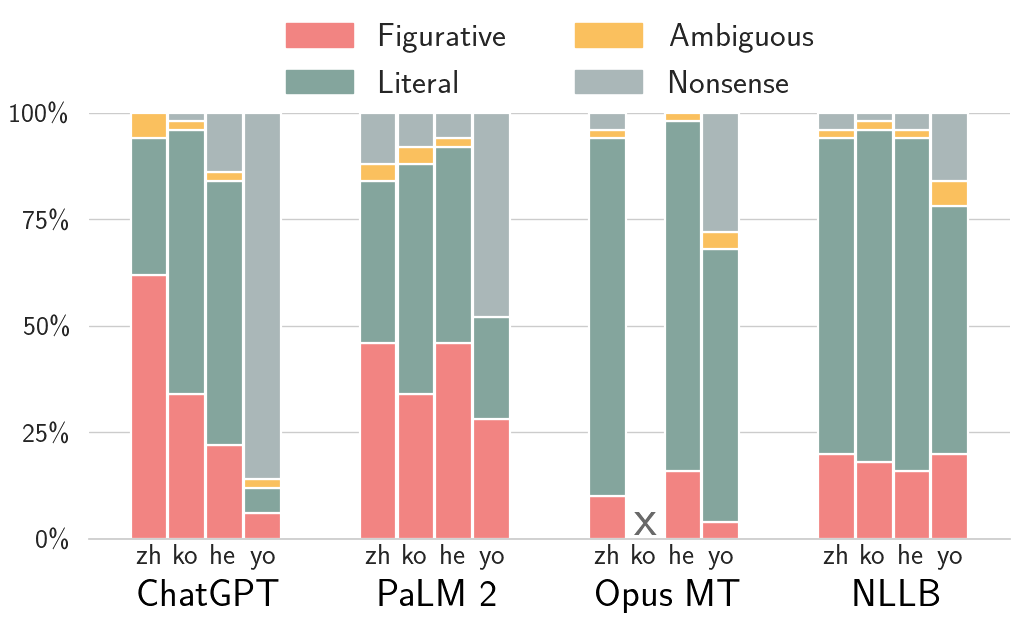

/var/folders/92/6j34w0196yq0cnnrfrw0s68w0000gn/T/ipykernel_2792/1889639916.py:63: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=status_colors[status], edgecolor='black') for status in status_order]


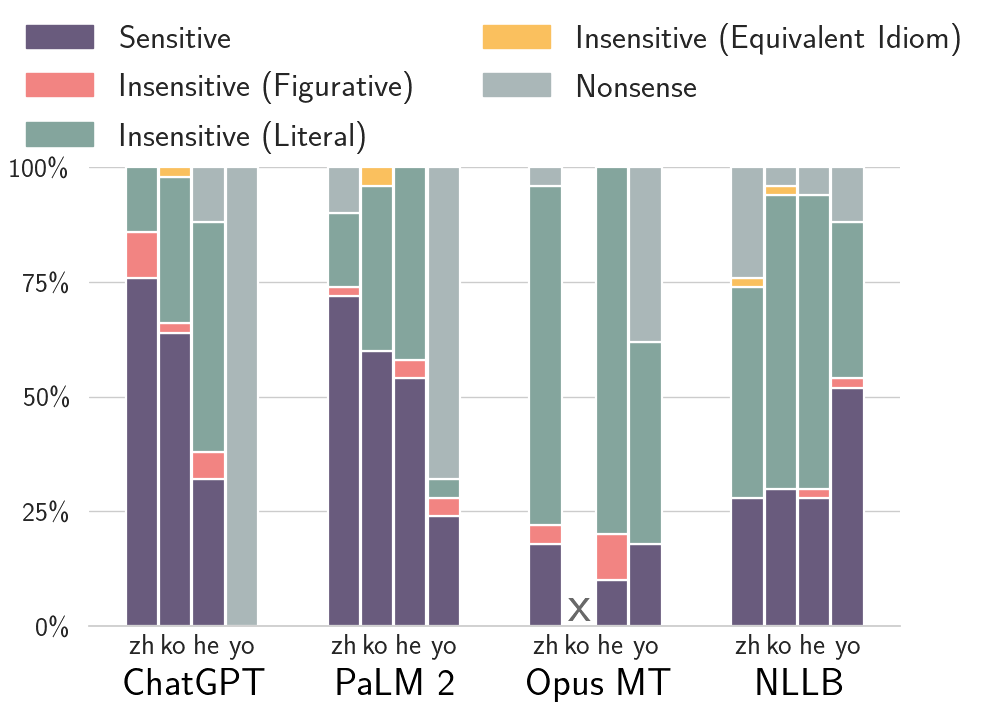

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn")
sns.set_theme(style="whitegrid")


def plot_grouped_stacked_bar(df, model_colors, status_colors, models_order, langs_order, status_order, output_path, legend_ncols, fig_size):
    
    # Count occurrences
    df_count = df.groupby(['model', 'lang', 'status']).size().reset_index(name='counts')

    # Calculate proportions
    df_total = df_count.groupby(['model', 'lang']).agg({'counts': 'sum'})
    df_count['proportion'] = df_count.apply(lambda row: row['counts'] / df_total.loc[(row['model'], row['lang'])], axis=1)

    fig, ax = plt.subplots(figsize=fig_size)

    bar_width = 0.16
    bar_edge_color = "white"
    spacing = 0.005

    # Create grouped stacked bar plot
    for lang_idx, lang in enumerate(langs_order):
        for model_idx, model in enumerate(models_order):
            bottom = 0
            for status in status_order:
                row = df_count[(df_count['model'] == model) & (df_count['lang'] == lang) & (df_count['status'] == status)]
                if not row.empty:
                    
                    # If data is "N/A" for "ko" and "Opus MT", place an "x" mark instead of drawing a bar
                    if model == 'opus' and lang == 'ko' and status == 'N/A':
                        x_position = model_idx + (lang_idx*(bar_width+spacing))
                        ax.text(x_position, 0.04, 'x', ha='center', va='center', color='dimgray', fontsize=38)
                        continue  # skip drawing the bar

                    ax.bar(model_idx + (lang_idx*(bar_width+spacing)), 
                           row['proportion'].values[0], bottom=bottom, 
                           color=status_colors[status], edgecolor=bar_edge_color, 
                           width=bar_width, linewidth=1.6)
                    bottom += row['proportion'].values[0]

    # Set model colors
    for lang_idx in range(len(langs_order)):
        [t.set_color(model_colors[model]) for (model, t) in zip(models_order, ax.xaxis.get_ticklabels()[lang_idx::len(langs_order)])]

    # Set labels and title
    ax.set_xticks([r + (bar_width * len(langs_order) / 2) - 0.05 for r in range(len(models_order))])
    ax.set_xticklabels([m(model) for model in models_order], color="black", fontsize=28,  position=(0.1,-0.05))
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{}\%'.format(int(x*100)) for x in np.linspace(0, 1, 5)], fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for model_idx, model in enumerate(models_order):
        for lang_idx, lang in enumerate(langs_order):
            ax.text(model_idx + (lang_idx*(bar_width+spacing)), -0.06, lang, ha='center', fontsize=21)

    plt.ylim(0, 1)

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=status_colors[status], edgecolor='black') for status in status_order]
    plt.legend(handles, [e for e in status_order if e != "N/A"], loc='upper center', bbox_to_anchor=(0.5, 1.38 if legend_ncols==2 else 1.28), ncols=2, fontsize=24)

    for d in {'top', 'right', 'left'}:
        ax.spines[d].set_visible(False)

    plt.tight_layout(pad=0)
    plt.savefig(output_path, bbox_inches="tight")
    plt.show()


# Usage Example:

model_order = ['gpt', 'palm', 'opus', 'nllb']
lang_order = ['zh', 'ko', 'he', 'yo']

# Script 1:
df1 = rq1
model_colors1 = {'gpt': '#E9967A', 'palm': '#E9967A', 'opus': '#800080', 'nllb': '#800080'}
status_colors1 = {'Figurative': "#F28482", 'Literal': "#84A59D", 'Ambiguous': '#FAC05E', 'Nonsense': '#AAB7B8', 'N/A': 'dimgray'}
status_order1 = ['Figurative', 'Literal', 'Ambiguous', 'Nonsense', 'N/A']
output_path1 = "./figures/rq1_human.png"
plot_grouped_stacked_bar(df1, model_colors1, status_colors1, model_order, lang_order, status_order1, output_path1, 3, (10, 6.2))

# Script 2:
df2 = rq2
status_colors2 = {'Sensitive': '#695B7D', 'Insensitive (Figurative)': '#F28482', 
                  'Insensitive (Literal)': '#84A59D', 'Insensitive (Equivalent Idiom)': '#FAC05E', 'Nonsense': '#AAB7B8', 'N/A': 'dimgray'}
status_order2 = ["Sensitive", "Insensitive (Figurative)", "Insensitive (Literal)", "Insensitive (Equivalent Idiom)", "Nonsense", "N/A"]
output_path2 = "./figures/rq2_human.png"
plot_grouped_stacked_bar(df2, model_colors1, status_colors2, model_order, lang_order, status_order2, output_path2, 2, (10, 7.4))

/var/folders/92/6j34w0196yq0cnnrfrw0s68w0000gn/T/ipykernel_3047/141092011.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/var/folders/92/6j34w0196yq0cnnrfrw0s68w0000gn/T/ipykernel_3047/141092011.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=status_colors[status], edgecolor='black') for status in status_order]


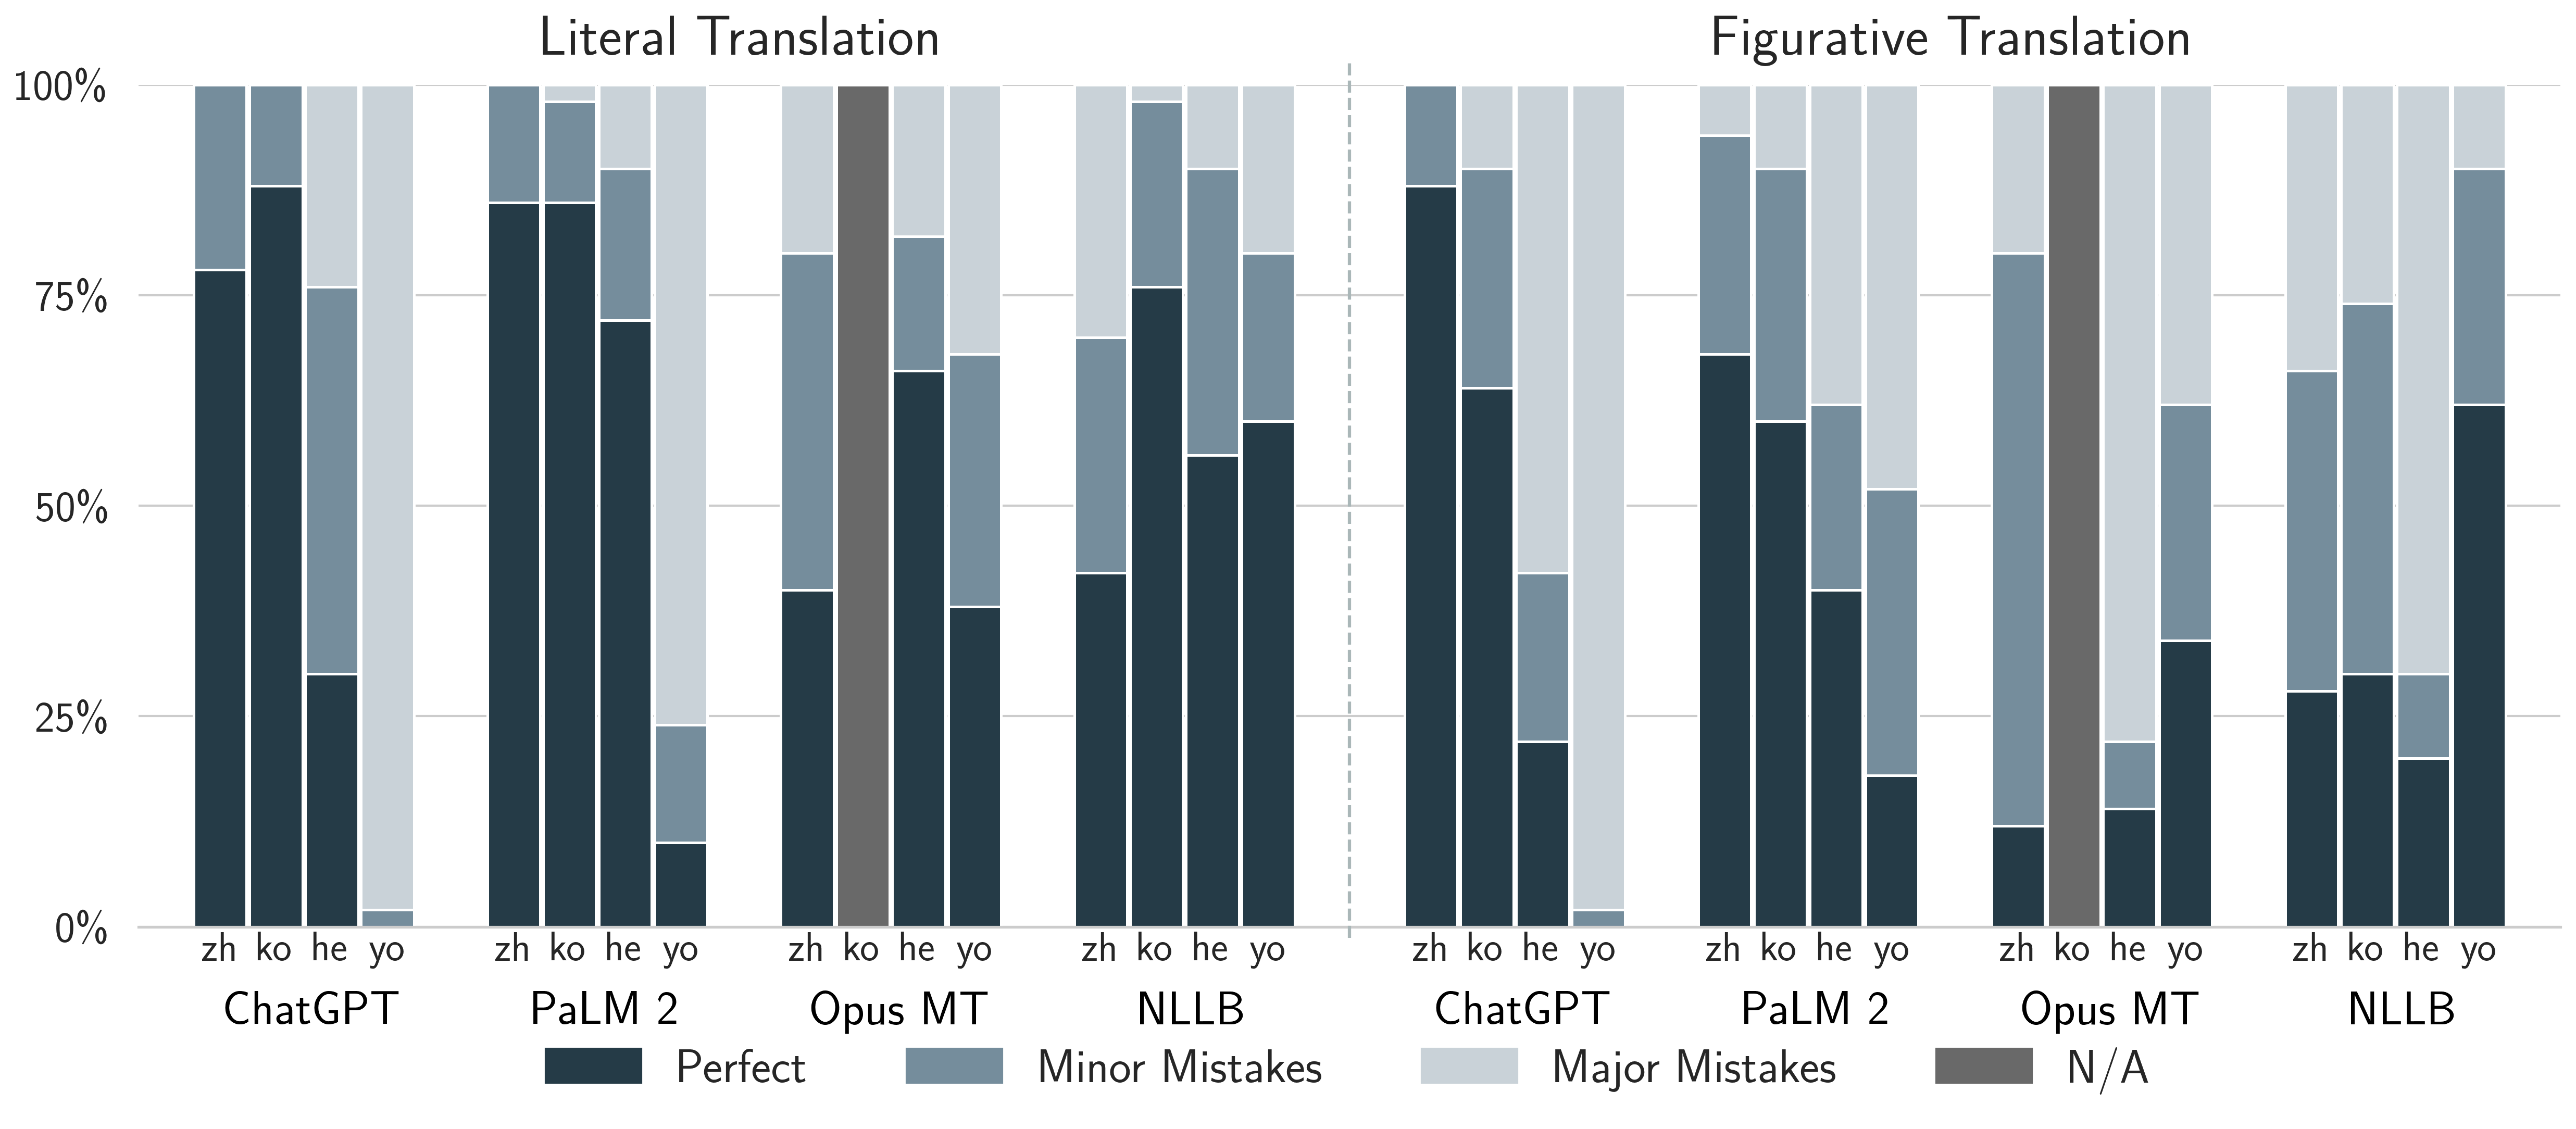

In [179]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
plt.style.use("seaborn")
sns.set_theme(style="whitegrid")

dfs = [rq3_lit, rq3_fig]

# The order of the models, languages, and statuses
models_order = ['gpt', 'palm', 'opus', 'nllb']
langs_order = ['zh', 'ko', 'he', 'yo']
status_order = ["Perfect", "Minor Mistakes", "Major Mistakes", "N/A"]

# Colors for the models and statuses
model_colors = {'gpt': '#E9967A', 'palm': '#E9967A', 'opus': '#800080', 'nllb': '#800080'}
status_colors = {'Perfect': '#253B47', 'Minor Mistakes': '#758D9C', 'Major Mistakes': '#C9D2D8', 'N/A': 'dimgray'}

# Spacing and appearance parameters
bar_width = 0.18
bar_edge_color = "white"
opacity = 0.4
spacing = 0.01

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True, dpi=300)  # Creating two subplots side by side sharing the y-axis

for ax_idx, ax in enumerate(axes):
    df = dfs[ax_idx]
    
    # Count occurrences and calculate proportions
    df_count = df.groupby(['model', 'lang', 'status']).size().reset_index(name='counts')
    df_total = df_count.groupby(['model', 'lang']).agg({'counts': 'sum'})
    df_count['proportion'] = df_count.apply(lambda row: row['counts'] / df_total.loc[(row['model'], row['lang'])], axis=1)

    # Create grouped stacked bar plot
    for lang_idx, lang in enumerate(langs_order):
        for model_idx, model in enumerate(models_order):
            bottom = 0
            for status in status_order:
                row = df_count[(df_count['model'] == model) & (df_count['lang'] == lang) & (df_count['status'] == status)]
                if not row.empty:
                    ax.bar(model_idx + (lang_idx*(bar_width+spacing)), 
                           row['proportion'].values[0], bottom=bottom, 
                           color=status_colors[status], edgecolor=bar_edge_color, 
                           width=bar_width, linewidth=1.2)
                    bottom += row['proportion'].values[0]

    # Set model colors
    for lang_idx in range(len(langs_order)):
        [t.set_color(model_colors[model]) for (model, t) in zip(models_order, ax.xaxis.get_ticklabels()[lang_idx::len(langs_order)])]

    for d in {'top', 'right', 'left'}:
        ax.spines[d].set_visible(False)

    # Set labels and title
    ax.set_xticks([r + (bar_width * len(langs_order) / 2)-0.04 for r in range(len(models_order))])
    ax.set_xticklabels([m(model) for model in models_order], color="black", fontsize=22,  position=(0,-0.042))
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{}\%'.format(int(x*100)) for x in np.linspace(0, 1, 5)], fontsize=20)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for model_idx, model in enumerate(models_order):
        for lang_idx, lang in enumerate(langs_order):
            ax.text(model_idx + (lang_idx*(bar_width+spacing)), -0.04, lang, ha='center', fontsize=19)

    
# Draw a line in the middle of two plots
axes[0].set_title("Literal Translation", fontsize=26, y=1.02)
axes[1].set_title("Figurative Translation", fontsize=26, y=1.02)

# Draw a line in the middle of two plots
bounds1 = axes[0].get_position().bounds
bounds2 = axes[1].get_position().bounds
line_x = bounds1[0] + bounds1[2] + (bounds2[0] - (bounds1[0] + bounds1[2])) / 2
# Add the line to the figure
line = Line2D([line_x, line_x], [0.1, 0.9], transform=fig.transFigure, color='#AAB7B8', linestyle='--')
fig.lines.append(line)
plt.subplots_adjust(wspace=0)

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=status_colors[status], edgecolor='black') for status in status_order]
plt.legend(handles, status_order, loc='lower center', bbox_to_anchor=(0, -0.25), ncols=4, fontsize=22)
plt.savefig("./figures/rq3_human.png", bbox_inches="tight")
plt.show()